 # Delayed Flights Neural Network

In [43]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#  Import and read data.
import pandas as pd 
data = "https://airport-efficiency.s3.amazonaws.com/Merged_cleaned_airport_data.csv"
df = pd.read_csv(data)
df.head()

,YEAR,MONTH,DAY_OF_WEEK,BRANDED_CODE_SHARE,ORIGIN,DEST,DEST_STATE_NM,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,...,DIVERTED,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,DELAYED,DATE,COVID,DELAY_REASON
0,2018,1,1,UA,BWI,DEN,Colorado,1608,1600.0,-8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-01-22,0.0,0.0
1,2018,1,1,UA,BWI,ORD,Illinois,1644,1637.0,-7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-01-22,0.0,0.0
2,2018,1,1,UA,BWI,IAH,Texas,1806,1800.0,-6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-01-22,0.0,0.0
3,2018,1,1,UA,BWI,IAH,Texas,828,828.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-01-08,0.0,0.0
4,2018,1,1,UA,BWI,DEN,Colorado,810,802.0,-8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-01-08,0.0,0.0


In [4]:
# Combined Airline and their Codeshare
df.loc[(df.BRANDED_CODE_SHARE == "UA_CODESHARE"), "BRANDED_CODE_SHARE"] = "UA"
df.loc[(df.BRANDED_CODE_SHARE == "AA_CODESHARE"), "BRANDED_CODE_SHARE"] = "AA"
df.loc[(df.BRANDED_CODE_SHARE == "DL_CODESHARE"), "BRANDED_CODE_SHARE"] = "DL"
df.loc[(df.BRANDED_CODE_SHARE == "AS_CODESHARE"), "BRANDED_CODE_SHARE"] = "AS"

In [5]:
# Define regions
northeast = ['Massachusetts',
'Rhode Island',
'Connecticut',
'Vermont',
'New Hampshire',
'Maine',
'Pennsylvania',
'New Jersey',
'New York'
]

souteast = ['Georgia',
'North Carolina',
'South Carolina',
'Virginia',
'West Virginia',
'Kentucky',
'Tennessee',
'Mississippi',
'Alabama',
'Delaware',
'Maryland',
'Florida',
'Louisiana',
'Arkansas'
]

midwest = ['Minnesota',
'Wisconsin',
'Illinois',
'Ohio',
'Indiana',
'Michigan',
'Missouri',
'Iowa',
'Kansas',
'Nebraska',
'North Dakota',
'South Dakota'
]

southwest = ['New Mexico',
'Arizona',
'Oklahoma',
'Texas'
]

west = ['California',
'Colorado',
'Nevada',
'Hawaii',
'Alaska',
'Oregon',
'Utah',
'Idaho',
'Montana',
'Wyoming',
'Washington'
]

noncontinental = ['U.S. Virgin Islands',
'Puerto Rico'
]

In [6]:
# Add region column
regions=pd.DataFrame([northeast,souteast,midwest,southwest,west,noncontinental],index=['northeast','souteast','midwest','southwest','west','noncontinental'])
regions=regions.reset_index().melt('index')
df['Region'] = df['DEST_STATE_NM'].map(dict(zip(regions['value'],regions['index'])))

In [7]:
# drop more columns
drop = ['DEP_TIME','DEP_DELAY_GROUP',  'DEST_STATE_NM', 'DEST', 'DEP_DELAY', 'LATE_AIRCRAFT_DELAY', 'CARRIER_DELAY', 'WEATHER_DELAY', 'SECURITY_DELAY', 'NAS_DELAY', 'DELAY_REASON', 'CRS_DEP_TIME' ]
df_dropped = df.drop( drop , 1)

# Encode Columns 
using get_dummies

In [8]:
brand_df = pd.get_dummies(df_dropped, columns=["BRANDED_CODE_SHARE"])


In [9]:
origin_df = pd.get_dummies(brand_df, columns=["ORIGIN"])

In [10]:
region_df = pd.get_dummies(origin_df, columns=["Region"])

In [12]:
final_df = pd.get_dummies(region_df, columns=["DEP_TIME_BLK"])
final_df['DATE'] = pd.to_datetime(final_df['DATE'], format='%Y-%m-%d')
final_df['DAY_OF_MONTH'] = final_df.DATE.dt.day
final_df = final_df.drop('DATE', 1)


In [13]:
y = final_df["DELAYED"]
X = final_df.drop(columns=["DELAYED"])

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_scaler = sc.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [20]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
# hidden layers determined using 2/3 of input layer + output layer for first layer then halving for each following layer
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 =  number_input_features*(2/3)+2
hidden_nodes_layer2 = hidden_nodes_layer1/2

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 32)                1472      
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,017
Trainable params: 2,017
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [22]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=20)

Epoch 1/20
25382/25382 [==============================] - 21s 808us/step - loss: 0.4369 - accuracy: 0.8244
Epoch 2/20
25382/25382 [==============================] - 22s 860us/step - loss: 0.4297 - accuracy: 0.8263
Epoch 3/20
25382/25382 [==============================] - 22s 860us/step - loss: 0.4271 - accuracy: 0.8267
Epoch 4/20
25382/25382 [==============================] - 20s 795us/step - loss: 0.4259 - accuracy: 0.8271
Epoch 5/20
25382/25382 [==============================] - 21s 823us/step - loss: 0.4251 - accuracy: 0.8272
Epoch 6/20
25382/25382 [==============================] - 21s 839us/step - loss: 0.4247 - accuracy: 0.8274
Epoch 7/20
25382/25382 [==============================] - 21s 838us/step - loss: 0.4243 - accuracy: 0.8275
Epoch 8/20
25382/25382 [==============================] - 21s 823us/step - loss: 0.4240 - accuracy: 0.8277
Epoch 9/20
25382/25382 [==============================] - 21s 822us/step - loss: 0.4238 - accuracy: 0.8277
Epoch 10/20
25382/25382 [============

In [23]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8461/8461 - 4s - loss: 0.4236 - accuracy: 0.8277 - 4s/epoch - 507us/step
Loss: 0.42356884479522705, Accuracy: 0.8276654481887817


# Make Predictions

In [26]:
predictions = nn.predict(X_test_scaled)

8461/8461 [==============================] - 5s 533us/step


In [45]:
print(predictions[0:10])

[[0.11071737]
 [0.09217022]
 [0.1399978 ]
 [0.07706269]
 [0.0873981 ]
 [0.25808695]
 [0.14602451]
 [0.13558266]
 [0.07502235]
 [0.12689991]]


In [46]:
# Round predictions to be able to compare test data
rounded = [round(x[0]) for x in predictions]
print(rounded[0:10])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


# Validate the model using the test data

In [54]:
y_test.value_counts()

0.0    222850
1.0     47885
Name: DELAYED, dtype: int64

In [53]:
cmtx = pd.DataFrame(
    confusion_matrix(y_test, rounded, labels=[1, 0]), 
    index=['Actual Delayed (1)', 'Actual On-Time (0)'], 
    columns=['Predicted Delayed (1)', 'Predicted On-Time (0)']
    )
cmtx

,Predicted Delayed (1),Predicted On-Time (0)
Actual Delayed (1),4281,43604
Actual On-Time (0),3053,219797


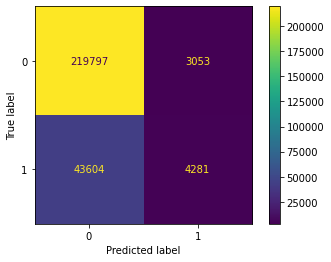

In [51]:
cm = ConfusionMatrixDisplay(confusion_matrix(y_test, rounded, labels=[0, 1]))
cm.plot()
plt.show()

In [42]:
print(classification_report(y_test, rounded))

              precision    recall  f1-score   support

         0.0       0.83      0.99      0.90    222850
         1.0       0.58      0.09      0.16     47885

    accuracy                           0.83    270735
   macro avg       0.71      0.54      0.53    270735
weighted avg       0.79      0.83      0.77    270735

